In [122]:
# Download required libraries
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import math
import os
from gym.wrappers.monitoring.video_recorder import VideoRecorder


from google.colab import drive
drive.mount('/content/drive') #connec to my drive to be able to save and loads files(trained agents)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
# Set up the environment
env = gym.make('MountainCarContinuous-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

# Hyperparameters
NUM_EPISODES = 50
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.01
ACTOR_LR = 1e-3
CRITIC_LR = 1e-4
BUFFER_SIZE = 100000
HIDDEN_LAYERS_ACTOR = 128
HIDDEN_LAYERS_CRITIC = 256

class Actor(nn.Module):
    """
    Actor network for the DDPG algorithm.
    """
    def __init__(self, state_dim, action_dim, max_action,use_batch_norm):
        """
        Initialise the Actor's Policy network.

        :param state_dim: Dimension of the state space
        :param action_dim: Dimension of the action space
        :param max_action: Maximum value of the action
        """
        super(Actor, self).__init__()
        self.bn1 = nn.LayerNorm(HIDDEN_LAYERS_ACTOR) if use_batch_norm else nn.Identity()
        self.bn2 = nn.LayerNorm(HIDDEN_LAYERS_ACTOR) if use_batch_norm else nn.Identity()

        self.l1 = nn.Linear(state_dim, HIDDEN_LAYERS_ACTOR)
        self.l2 = nn.Linear(HIDDEN_LAYERS_ACTOR, HIDDEN_LAYERS_ACTOR)
        self.l3 = nn.Linear(HIDDEN_LAYERS_ACTOR, action_dim)
        self.max_action = max_action

    def forward(self, state):
        """
        Forward propagation through the network.

        :param state: Input state
        :return: Action
        """

        a = torch.relu(self.bn1(self.l1(state)))
        a = torch.relu(self.bn2(self.l2(a)))
        return self.max_action * torch.tanh(self.l3(a))

class Critic(nn.Module):
    """
    Critic network for the DDPG algorithm.
    """
    def __init__(self, state_dim, action_dim,use_batch_norm):
        """
        Initialise the Critic's Value network.

        :param state_dim: Dimension of the state space
        :param action_dim: Dimension of the action space
        """
        super(Critic, self).__init__()
        self.bn1 = nn.BatchNorm1d(HIDDEN_LAYERS_CRITIC) if use_batch_norm else nn.Identity()
        self.bn2 = nn.BatchNorm1d(HIDDEN_LAYERS_CRITIC) if use_batch_norm else nn.Identity()
        self.l1 = nn.Linear(state_dim + action_dim, HIDDEN_LAYERS_CRITIC)

        self.l2 = nn.Linear(HIDDEN_LAYERS_CRITIC, HIDDEN_LAYERS_CRITIC)
        self.l3 = nn.Linear(HIDDEN_LAYERS_CRITIC, 1)

    def forward(self, state, action):
        """
        Forward propagation through the network.

        :param state: Input state
        :param action: Input action
        :return: Q-value of state-action pair
        """
        q = torch.relu(self.bn1(self.l1(torch.cat([state, action], 1))))
        q = torch.relu(self.bn2(self.l2(q)))
        return self.l3(q)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

"""
Taken from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
"""
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

class DDPG():
    """
    Deep Deterministic Policy Gradient (DDPG) agent.
    """
    def __init__(self, state_dim, action_dim, max_action,use_batch_norm):
        """
        [STEP 0]
        Initialise the DDPG agent.

        :param state_dim: Dimension of the state space
        :param action_dim: Dimension of the action space
        :param max_action: Maximum value of the action
        """

        # Initialise Actor's Policy network
        self.actor = Actor(state_dim, action_dim, max_action,use_batch_norm)
        # Initialise Actor target network with same weights as Actor's Policy network
        self.actor_target = Actor(state_dim, action_dim, max_action,use_batch_norm)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=ACTOR_LR)

        # Initialise Critic's Value network
        self.critic = Critic(state_dim, action_dim,use_batch_norm)
        # Initialise Crtic's target network with same weights as Critic's Value network
        self.critic_target = Critic(state_dim, action_dim,use_batch_norm)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=CRITIC_LR)

        # Initialise the Replay Buffer
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)

        # # Initialise noise
        # self.ou_noise = OUNoise(action_dim)

    def select_action(self, state):
        """
        [STEP 1]
        Select an action given the current state.

        :param state: Current state
        :return: Selected action
        """
        state = torch.FloatTensor(state.reshape(1, -1))
        action = self.actor(state).cpu().data.numpy().flatten()
        return action

    def train(self, use_target_network,use_batch_norm):
        """
        Train the DDPG agent.

        :param use_target_network: Whether to use target networks or not
        :param use_batch_norm: Whether to use batch normalisation or not
        """
        if len(self.replay_buffer) < BATCH_SIZE:
            return

        # Sample a batch from the replay buffer
        batch = self.replay_buffer.sample(BATCH_SIZE)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))

        state = torch.FloatTensor(state)
        action = torch.FloatTensor(action)
        next_state = torch.FloatTensor(next_state)
        reward = torch.FloatTensor(reward.reshape(-1, 1))
        done = torch.FloatTensor(done.reshape(-1, 1))

        # Critic update
        if use_target_network:
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
        else:
            target_Q = self.critic(next_state, self.actor(next_state))
        target_Q = reward + (1 - done) * GAMMA * target_Q
        current_Q = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q, target_Q.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        if use_target_network:
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [111]:
def train_ddpg(use_target_network, use_batch_norm, num_episodes=NUM_EPISODES):
    """
    Train the DDPG agent.

    :param use_target_network: Whether to use target networks
    :param use_batch_norm: Whether to use batch normalization
    :param num_episodes: Number of episodes to train
    :return: List of episode rewards
    """
    agent = DDPG(state_dim, action_dim, 1,use_batch_norm)

    episode_rewards = []
    noise = OUNoise(env.action_space)

    for episode in range(num_episodes):
        state= env.reset()
        noise.reset()
        episode_reward = 0
        done = False
        step=0
        while not done:
            action_actor = agent.select_action(state)
            action = noise.get_action(action_actor,step) # Add noise for exploration
            next_state, reward, done,_= env.step(action)
            done = float(done) if isinstance(done, (bool, int)) else float(done[0])
            agent.replay_buffer.push(state, action, reward, next_state, done)

            if len(agent.replay_buffer) > BATCH_SIZE:
                agent.train(use_target_network,use_batch_norm)

            state = next_state
            episode_reward += reward
            step+=1

        episode_rewards.append(episode_reward)

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}: Reward = {episode_reward}")

    return agent, episode_rewards

In [112]:
## Helper functions to save and load the trained agent

def save_model(agent, rewards,suffix, directory="/content/drive/MyDrive/trained_ddpg_agents"):
    """
    Save the agent's models and rewards to the specified directory.

    :param agent: The trained DDPG agent whose actor and critic models will be saved.
    :param rewards: List or array of rewards collected during training.
    :param suffix: A suffix to append to the filenames for the saved models and rewards file.
    :param directory: The directory where the models and rewards file will be saved (default is '/content/drive/MyDrive/trained_ddpg_agents').
    :return: None
    """
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
    actor_path =  os.path.join(directory,f"actor_{suffix}.pth")
    critic_path = os.path.join(directory,f"critic_{suffix}.pth")
    rewards_path = os.path.join(directory,f"rewards_{suffix}.npy")
    # Save the models
    torch.save(agent.actor.state_dict(), actor_path)
    torch.save(agent.critic.state_dict(), critic_path)
    np.save(rewards_path, rewards)
    print(f"Models saved to:\nActor: {actor_path}\nCritic: {critic_path}")

def load_model(agent, actor_path, critic_path):
    """
    Load the agent's actor and critic models from the specified file paths.

    :param agent: The DDPG agent whose models will be loaded.
    :param actor_path: Path to the saved actor model file.
    :param critic_path: Path to the saved critic model file.
    :return: None
    """
    agent.actor.load_state_dict(torch.load(actor_path))
    agent.critic.load_state_dict(torch.load(critic_path))
    print(f"Models loaded from:\nActor: {actor_path}\nCritic: {critic_path}")

def load_rewards(suffix):
    """
    Load the rewards from a saved file.

    :param suffix: The suffix used to create the rewards file name.
    :return: The loaded rewards as a NumPy array.
    """
    rewards_path=rewards_path=f"/content/drive/MyDrive/trained_ddpg_agents/rewards_{suffix}.npy"
    rewards = np.load(rewards_path)
    print(f"Rewards loaded from: {rewards_path}")
    return rewards


# Train and save DDPG agent and their rewards under different configurations
trained_agent1, rewards1=train_ddpg(use_target_network=True, use_batch_norm=True,num_episodes=NUM_EPISODES)
save_model(trained_agent1,rewards1,'1')
trained_agent2, rewards2=train_ddpg(use_target_network=True, use_batch_norm=False,num_episodes=NUM_EPISODES)
save_model(trained_agent2, rewards2,'2')
trained_agent3, rewards3=train_ddpg(use_target_network=False, use_batch_norm=True,num_episodes=NUM_EPISODES)
save_model(trained_agent3,rewards3,'3')
trained_agent4, rewards4=train_ddpg(use_target_network=False, use_batch_norm=False,num_episodes=NUM_EPISODES)
save_model(trained_agent4,rewards4,'4')

Episode 10: Reward = -36.82727836471752
Episode 20: Reward = 79.40082209592707
Episode 30: Reward = 94.84079325251575
Episode 40: Reward = 91.38052545608168
Episode 50: Reward = 87.0785142954992
Models saved to:
Actor: /content/drive/MyDrive/trained_ddpg_agents/actor_mountain_car.pth
Critic: /content/drive/MyDrive/trained_ddpg_agents/critic_mountain_car.pth


Rewards loaded from: /content/drive/MyDrive/trained_ddpg_agents/rewards_mountain_car.npy


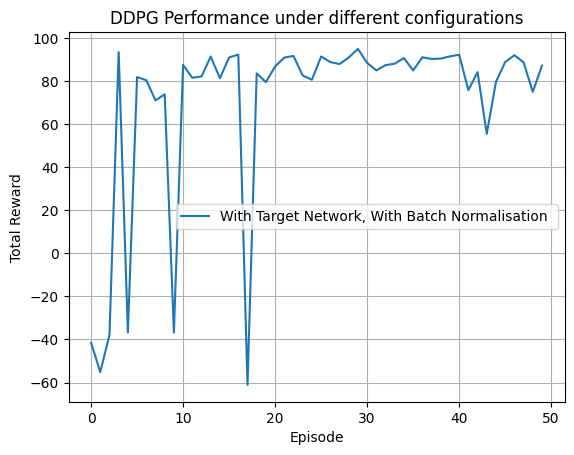

In [113]:
# Load rewards obtained under each configuration
rewards_1=load_rewards(1)
rewards_2=load_rewards(2)
rewards_3=load_rewards(3)
rewards_4=load_rewards(4)

# Visualise results
plt.figure(figsize=(12, 6))
plt.plot(rewards_4, label='Without Target Network, Without Batch Normalisation')
plt.plot(rewards_2, label='With Target Networks, Without Batch Normalisation')
plt.plot(rewards_3, label='Without Target Networks, With Batch Normalisation')
plt.plot(rewards_1, label='With Target Network, With Batch Normalisation ')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DDPG Performance under different configurations')
plt.legend()
plt.grid(True)
plt.show()


In [123]:
# Use the trained agent to play the game
def play_and_record_game(agent, num_episodes, video_filename, env_name='MountainCarContinuous-v0'):
    """
    Play and record a game session with a trained agent.

    :param agent: The trained DDPG agent that will interact with the environment and select actions.
    :param num_episodes: Number of episodes to run the environment for.
    :param video_filename: The name of the video file where the recorded frames will be saved.
    :param env_name: The name of the Gym environment to use (default is 'MountainCarContinuous-v0').
    :return: None
    """
    # Set up video recording
    cwd = os.getcwd()
    video_dir = os.path.join(cwd, 'video_recordings')
    if not os.path.isdir(video_dir):
        os.mkdir(video_dir)
    video_file = os.path.join(video_dir, video_filename)

    # Initialise environment
    env = gym.make(env_name, render_mode="rgb_array")
    video_recorder = VideoRecorder(env, video_file, enabled=True)

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state).float()
        total_reward = 0
        done = False
        count =0
        while not done:
            # Record the current frame
            video_recorder.capture_frame()

            # Agent selects an action
            action = agent.select_action(state.numpy())
            next_state, reward, done,_= env.step(action)
            done = float(done) if isinstance(done, (bool, int)) else float(done[0])
            total_reward += reward
            state = torch.FloatTensor(next_state).float()
            count+=1

        print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

    # Finalise video recording
    video_recorder.close()
    video_recorder.enabled = False
    env.close()

    print(f"Video saved at: {video_file}")

# Initialise DDPG agent
agent1 = DDPG(state_dim, action_dim, max_action,use_batch_norm=True)

# Load the trained agent using specific file paths.
load_model(agent1,
           actor_path="/content/drive/MyDrive/trained_ddpg_agents/actor_1.pth",
           critic_path="/content/drive/MyDrive/trained_ddpg_agents/critic_1.pth")


play_and_record_game(agent1, env_name='MountainCarContinuous-v0', num_episodes=12, video_filename="mountain_car.mp4")

from IPython.display import Video
Video("video_recordings/mountain_car.mp4", embed=True)


<ipython-input-112-2bbf729af676>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.actor.load_state_dict(torch.load(actor_path))
<ipython-input-112-2bbf729af676>:18: F

Models loaded from:
Actor: /content/drive/MyDrive/trained_ddpg_agents/actor_1.pth
Critic: /content/drive/MyDrive/trained_ddpg_agents/critic_1.pth


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward = 94.81
Episode 2: Total Reward = 93.27
Episode 3: Total Reward = 86.96
Episode 4: Total Reward = 86.99
Episode 5: Total Reward = 94.83
Episode 6: Total Reward = 94.19
Episode 7: Total Reward = 94.30
Episode 8: Total Reward = 94.61
Episode 9: Total Reward = 94.59
Episode 10: Total Reward = 94.34
Episode 11: Total Reward = 93.34
Episode 12: Total Reward = 86.94
Video saved at: /content/video_recordings/mountain_car.mp4
